[[이유한님] 캐글 코리아 캐글 스터디 커널 커리큘럼](https://kaggle-kr.tistory.com/32)

[2nd level. Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction)

# [Data Preparation & Exploration](https://www.kaggle.com/code/bertcarremans/data-preparation-exploration/notebook)

This notebook aims at getting a good insight in the data for the PorteSeguro competition. Besides that, it gives some tips and tricks to prepare your data for modeling. The notebook consists of the following main sections:

1. Visual inspection of your data
2. Defining the metadata
3. Descriptive statistics
4. Handling imbalanced classes
5. Data quality checks
6. Exploratory data visualization
7. Feature engineering
8. Feature selection
9. Feature scaling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# from sklearn.preprocessing import Imputer 변경된 듯
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

# pd.set_option('display.max_columns', 100)

## Data at first sight
Here is an excerpt of the the data description for the competition:  
  
- Features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc).
- Feature names include the postfix bin to indicate binary features and cat to indicate categorical features.
- Features without these designations are either continuous or ordinal.
- Values of -1 indicate that the feature was missing from the observation.
- The target columns signifies whether or not a claim was filed for that policy holder.
   
Ok, that's important information to get us started. Let's have a quick look at the first and last rows to confirm all of this.  
  
#### DeeL 번역
다음은 대회에 대한 데이터 설명의 발췌문입니다:  
  
- 유사한 그룹에 속하는 피처는 피처 이름에 해당 그룹으로 태그가 지정됩니다(예: ind, reg, car, calc).
- 특징 이름에는 이진 특징을 나타내는 최종 추가 bin과 범주형 특징을 나타내는 cat이 포함됩니다.
- 이러한 지정이 없는 특징은 연속형 또는 서수형입니다.
- 값이 -1이면 해당 특징이 관찰에서 누락되었음을 나타냅니다.
- 대상 열은 해당 보험 계약자에 대한 보험금 청구가 접수되었는지 여부를 나타냅니다.
   
자, 이제 시작하기 위한 중요한 정보입니다. 이 모든 것을 확인하기 위해 첫 번째 행과 마지막 행을 간단히 살펴보겠습니다.

In [2]:
train = pd.read_csv('./input/002_porto-seguro-safe-driver-prediction/train.csv')
test = pd.read_csv('./input/002_porto-seguro-safe-driver-prediction/test.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,...,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,...,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,...,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,...,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,...,4,4,3,8,0,1,0,0,0,0


We indeed see the following  
  
- binary variables  
- categorical variables of which the category values are integers  
- other variables with integer or float values  
- variables with -1 representing missing values  
- the target variable and an ID variable  

In [4]:
print(train.shape)
train.drop_duplicates() # 중복 값 제거
print(train.shape)
train.info()

(595212, 59)


(595212, 59)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 1

In [5]:
print(test.shape)
train.drop_duplicates() # 중복 값 제거
print(test.shape)
test.info()

(892816, 58)
(892816, 58)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              892816 non-null  int64  
 1   ps_ind_01       892816 non-null  int64  
 2   ps_ind_02_cat   892816 non-null  int64  
 3   ps_ind_03       892816 non-null  int64  
 4   ps_ind_04_cat   892816 non-null  int64  
 5   ps_ind_05_cat   892816 non-null  int64  
 6   ps_ind_06_bin   892816 non-null  int64  
 7   ps_ind_07_bin   892816 non-null  int64  
 8   ps_ind_08_bin   892816 non-null  int64  
 9   ps_ind_09_bin   892816 non-null  int64  
 10  ps_ind_10_bin   892816 non-null  int64  
 11  ps_ind_11_bin   892816 non-null  int64  
 12  ps_ind_12_bin   892816 non-null  int64  
 13  ps_ind_13_bin   892816 non-null  int64  
 14  ps_ind_14       892816 non-null  int64  
 15  ps_ind_15       892816 non-null  int64  
 16  ps_ind_16_bin   892816 non-nul

We are missing one variable in the test set, but this is the target variable. So that's fine.  
Let's now invesigate how many variables of each type we have.  
  
So later on we can create dummy variables for the 14 categorical variables. The bin variables are already binary and do not need dummification.

## Metadata
To facilitate the data management, we'll store meta-information about the variables in a DataFrame. This will be helpful when we want to select specific variables for analysis, visualization, modeling, ...  
  
Concretely we will store:  
- role: input, ID, target
- level: nominal, interval, ordinal, binary
- keep: True or False
- dtype: int, float, str

In [6]:
data = []
for f in train.columns:
    # Defining the role
    if f=='target': 
        role = 'target'
    elif f=='id':
        role = 'id'
    else:
        role = 'input'

    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype=='float64':
        level = 'interval'
    elif train[f].dtype=='int64':
        level = 'ordinal'

    # Initialize keep to True for all variables except for id
    keep = False if f=='id' else True

    # Defining the data type
    dtype = train[f].dtype

    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)

meta = pd.DataFrame(data=data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
# meta = pd.DataFrame(data=data, columns=list(f_dict.keys()))
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [7]:
meta[(meta.level=='nominal')&(meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [8]:
pd.DataFrame({'count': meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


## Descriptive statistics
We can also apply the describe method on the dataframe. However, it doesn't make much sense to calculate the mean, std, ... on categorical variables and the id variable. We'll explore the categorical variables visually later.  
  
Thanks to our meta file we can easily select the variables on which we want to compute the descriptive statistics. To keep things clear, we'll do this per data type.  

#### DeepL 번역
데이터 프레임에 설명 방법을 적용할 수도 있습니다. 그러나 범주형 변수와 ID 변수에 대해 평균, 표준편차, ...를 계산하는 것은 그다지 의미가 없습니다. 범주형 변수는 나중에 시각적으로 살펴보겠습니다.  
  
메타 파일 덕분에 설명적 통계를 계산할 변수를 쉽게 선택할 수 있습니다. 명확하게 하기 위해 데이터 유형별로 이 작업을 수행하겠습니다.

In [9]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


__reg variables__  
- only ps_reg_03 has missing values
- the range (min to max) differs between the variables. We could apply scaling (e.g. StandardScaler), but it depends on the classifier we will want to use.  
  
__car variables__  
- ps_car_12 and ps_car_15 have missing values
- again, the range differs and we could apply scaling.
  
__calc variables__  
- no missing values
- this seems to be some kind of ratio as the maximum is 0.9
- all three _calc variables have very similar distributions  
  
Overall, we can see that the range of the interval variables is rather small. Perhaps some transformation (e.g. log) is already applied in order to anonymize the data?

In [10]:
## Ordinal variables
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [11]:
## Binary variables
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Handling imbalanced classes
As we mentioned above the proportion of records with target=1 is far less than target=0. This can lead to a model that has great accuracy but does have any added value in practice. Two possible strategies to deal with this problem are:  
- oversampling records with target=1
- undersampling records with target=0  
  
There are many more strategies of course and MachineLearningMastery.com gives a nice overview. As we have a rather large training set, we can go for undersampling.

In [12]:
desired_aprioir = 0.10

## Get the indices per target value
idx_0 = train[train.target==0].index
idx_1 = train[train.target==1].index

## Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

## Calculates the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_aprioir)*nb_1)/(nb_0*desired_aprioir)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0:', undersampling_rate)
print('Number of records with target=0 after undersampling:', undersampled_nb_0)

# print(train.shape, nb_0, nb_1)
# print((1-desired_aprioir)*nb_1, '/', nb_0*desired_aprioir, ((1-desired_aprioir)*nb_1)/(nb_0*desired_aprioir))

## Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

## Construct list with remaing indices
idx_list = list(undersampled_idx) + list(idx_1)

## Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


## Data Quality Checks

In [13]:
## Checking missing values

vars_with_missing = []
# for f in train.columns.sort_values():
for f in train.columns:
    missings = train[train[f]==-1][f].count()
    if missings>0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]

        print(f'Variable {f:<13} has {missings:>6} record ({missings_perc:>6.2%}) with missing values')

print(f'In total, there are {len(vars_with_missing)} variables with missing values')

Variable ps_ind_02_cat has    103 record ( 0.05%) with missing values
Variable ps_ind_04_cat has     51 record ( 0.02%) with missing values
Variable ps_ind_05_cat has   2256 record ( 1.04%) with missing values
Variable ps_reg_03     has  38580 record (17.78%) with missing values
Variable ps_car_01_cat has     62 record ( 0.03%) with missing values
Variable ps_car_02_cat has      2 record ( 0.00%) with missing values
Variable ps_car_03_cat has 148367 record (68.39%) with missing values
Variable ps_car_05_cat has  96026 record (44.26%) with missing values
Variable ps_car_07_cat has   4431 record ( 2.04%) with missing values
Variable ps_car_09_cat has    230 record ( 0.11%) with missing values
Variable ps_car_11     has      1 record ( 0.00%) with missing values
Variable ps_car_14     has  15726 record ( 7.25%) with missing values
In total, there are 12 variables with missing values


- __ps_car_03_cat and ps_car_05_cat__ have a large proportion of records with missing values. Remove these variables.
- For the other categorical variables with missing values, we can leave the missing value -1 as such.
- __ps_reg_03__ (continuous) has missing values for 18% of all records. Replace by the mean.
- __ps_car_11__ (ordinal) has only 5 records with misisng values. Replace by the mode.
- __ps_car_12__ (continuous) has only 1 records with missing value. Replace by the mean.
- __ps_car_14__ (continuous) has missing values for 7% of all records. Replace by the mean.

In [14]:
## Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop), 'keep'] = False    ## Updating the meta

## Imputing with the mean or mode
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']])
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']])
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']])
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']])
train[['ps_reg_03', 'ps_car_12', 'ps_car_14', 'ps_car_11']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216940 entries, 0 to 216939
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ps_reg_03  216940 non-null  float64
 1   ps_car_12  216940 non-null  float64
 2   ps_car_14  216940 non-null  float64
 3   ps_car_11  216940 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 6.6 MB


### Checking the cardinality of the categorical variables
Cardinality refers to the number of different values in a variable. As we will create dummy variables from the categorical variables later on, we need to check whether there are variables with many distinct values. We should handle these variables differently as they would result in many dummy variables.

In [15]:
v = meta[(meta.level=='nominal')&(meta.keep)].index
print(v)

for f in v:
    dist_values = train[f].value_counts().shape[0]
    # dist_values = train[f].nunique()
    print(f'Variable {f} has {dist_values} distinct values')

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')
Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


In [16]:
## Script by https://www.kaggle.com/ogrellier
## Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

def add_noise(series:pd.Series, noise_level:int) -> pd.Series:
    return series*(1+noise_level*np.random.randn(len(series)))

def traget_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    (위 링크 연결 안 됨)
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    ## Compute target mean
    averages = temp.groupby(trn_series.name)[target.name].agg(['mean', 'count'])
    ## Compute smoothing
    smoothing = 1/(1+np.exp(-(averages['count']-min_samples_leaf)/smoothing))
    ## Apply average function to all target data
    prior = target.mean()
    ## The bigger the count the less full_avg is taken into account
    averages[target.name] = prior*(1-smoothing)+averages['mean']*smoothing
    averages.drop(['mean','count'], axis=1, inplace=True)
    ## Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name+'_mean').fillna(prior)
    ## pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name+'mean').fillna(prior)
    ## pd.merge dose not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [17]:
train_encoded, test_encoded = traget_encode(train['ps_car_11_cat'],
                                            test['ps_car_11_cat'],
                                            target=train.target,
                                            min_samples_leaf=100,
                                            smoothing=10,
                                            noise_level=0.01)

train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat', 'keep'] = False   ## Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

## Exploratory Data Visualization

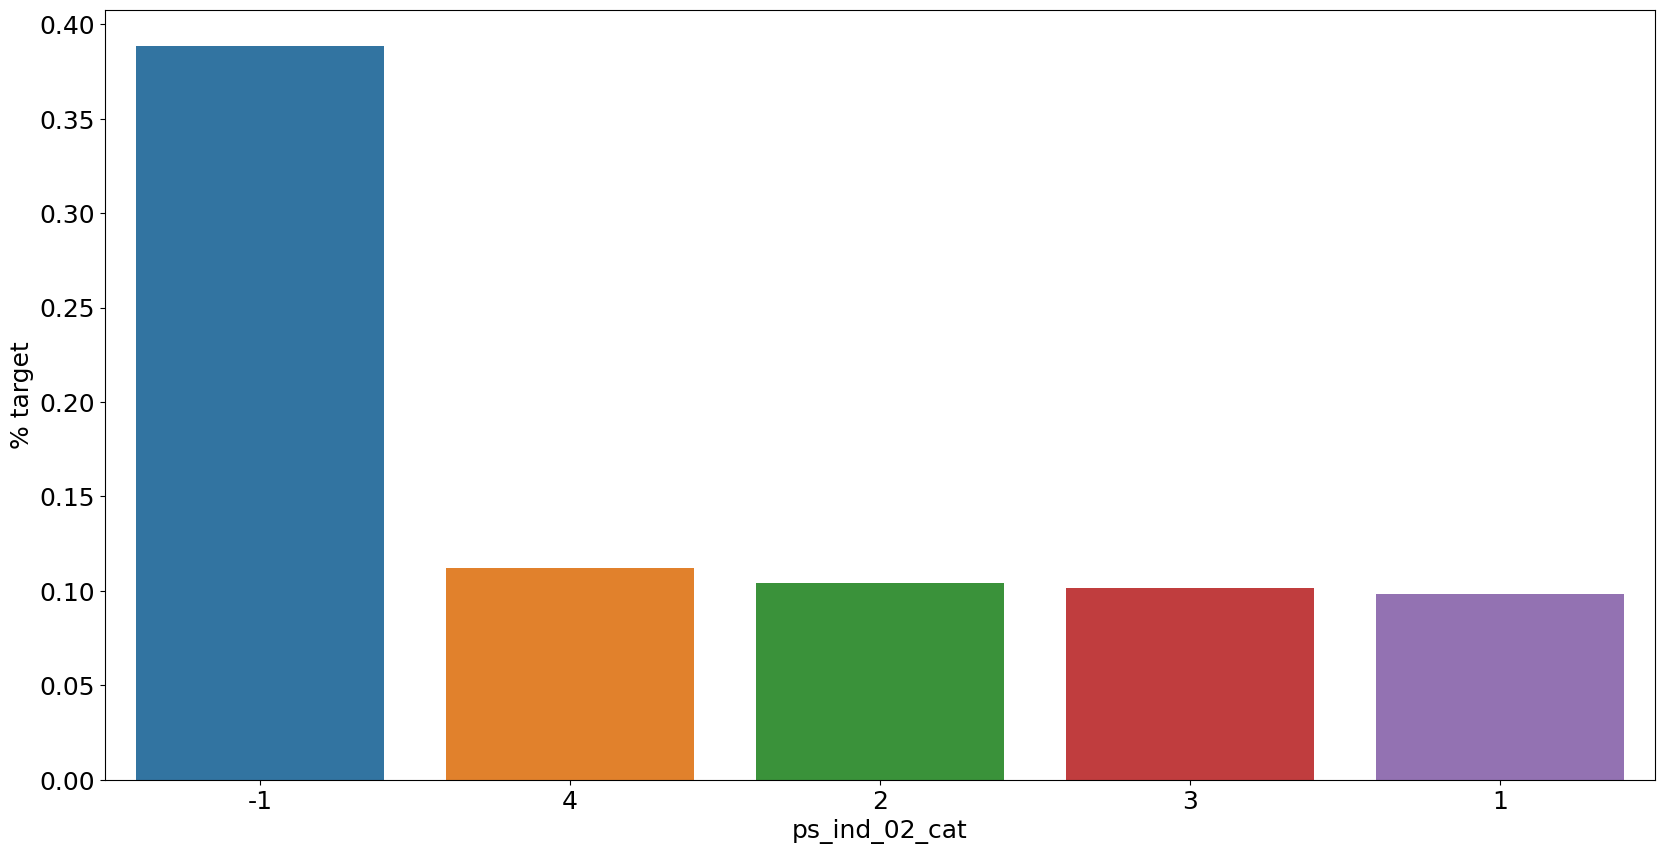

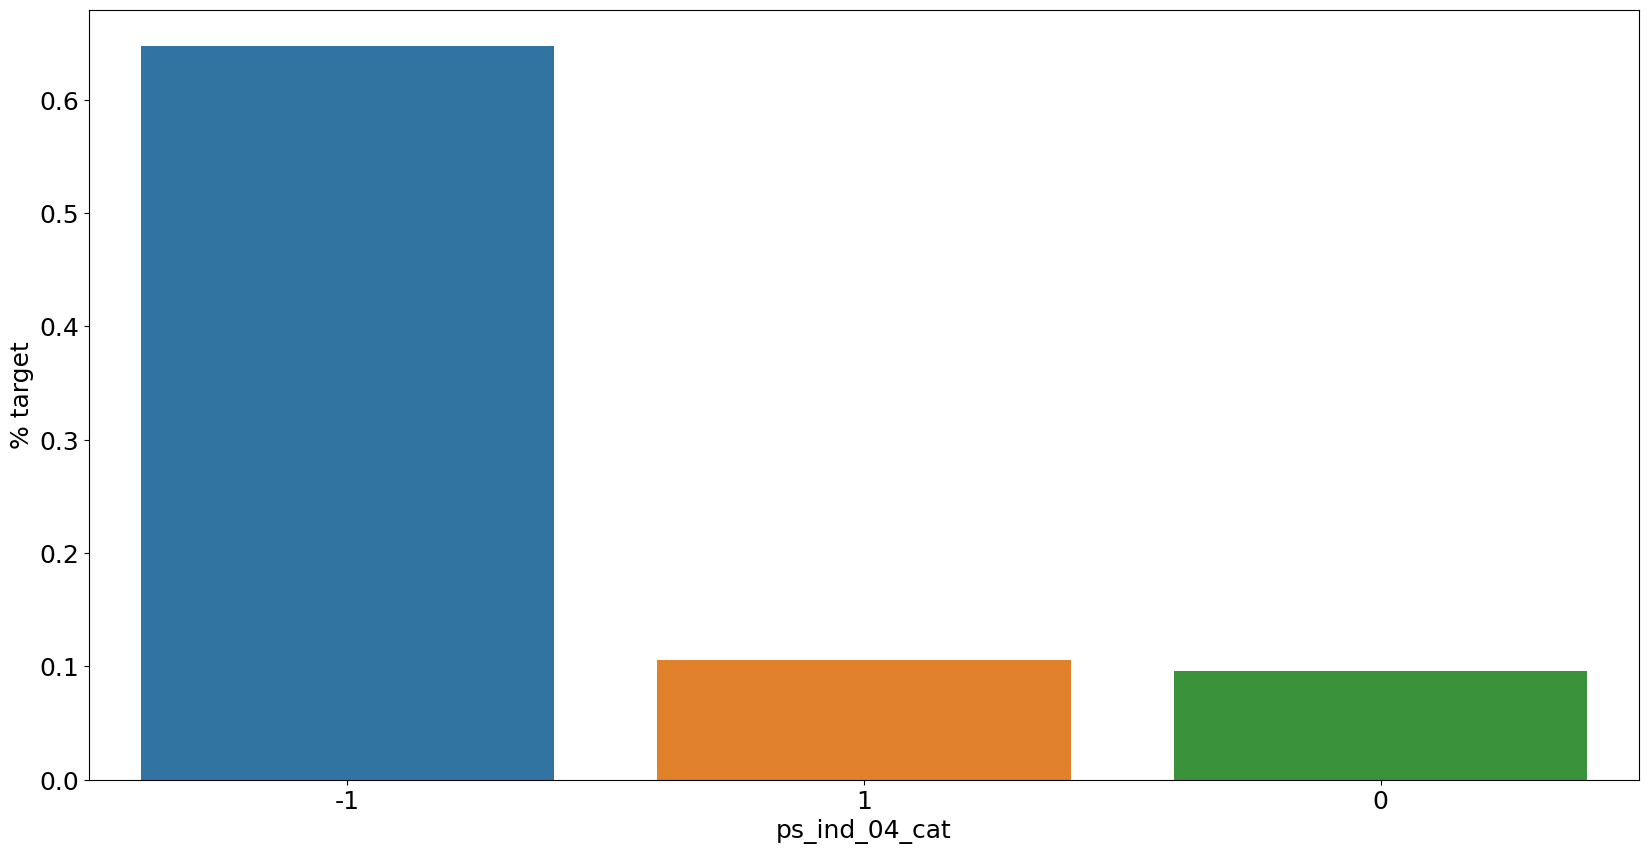

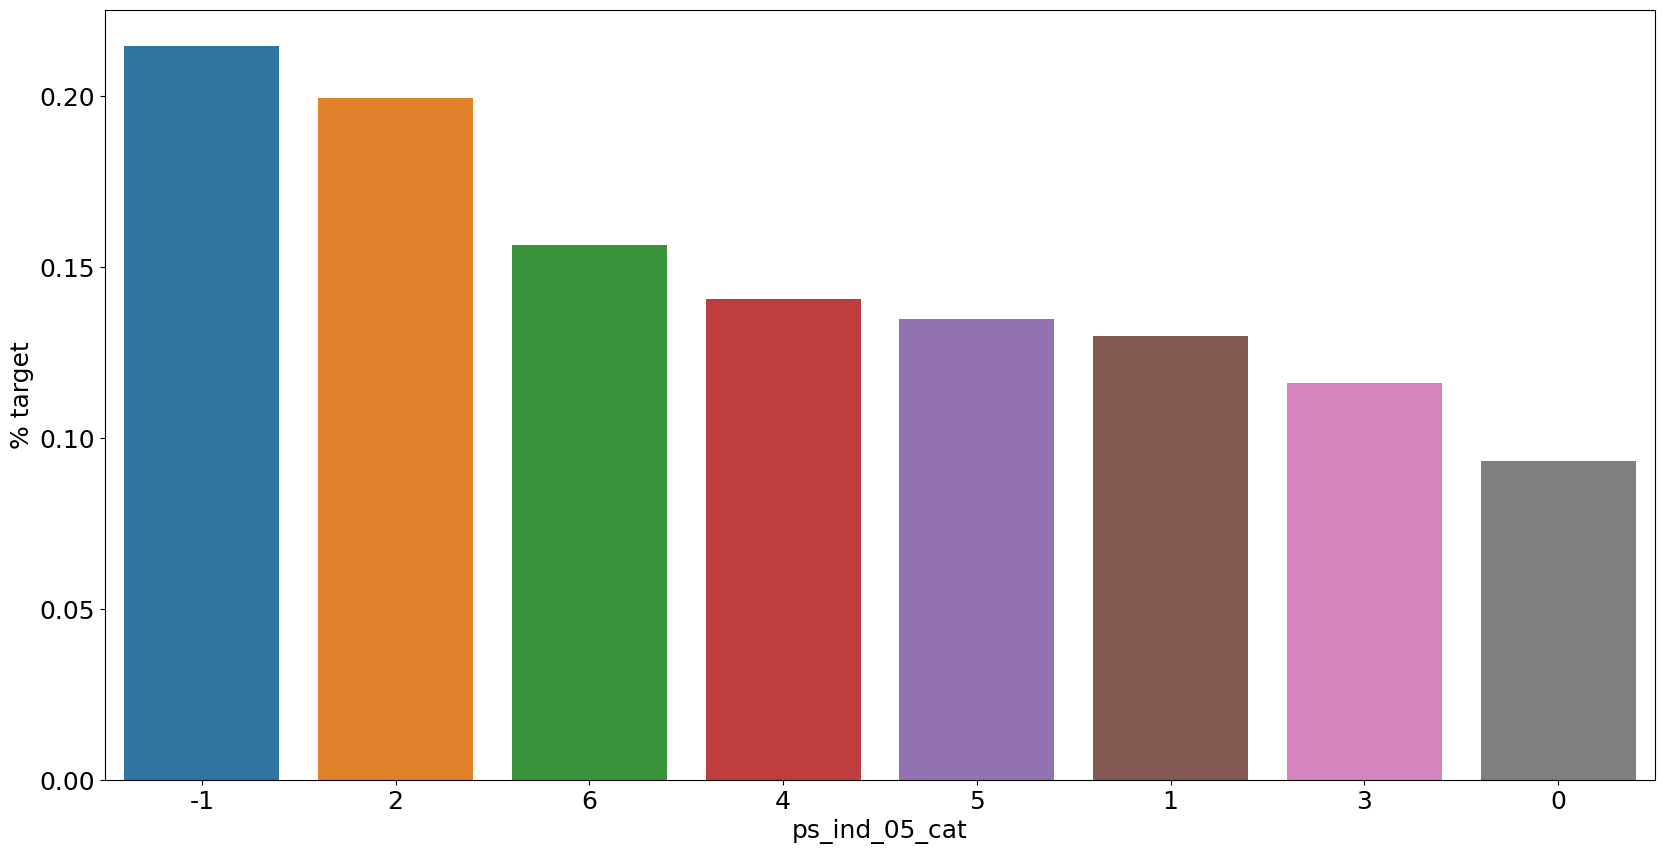

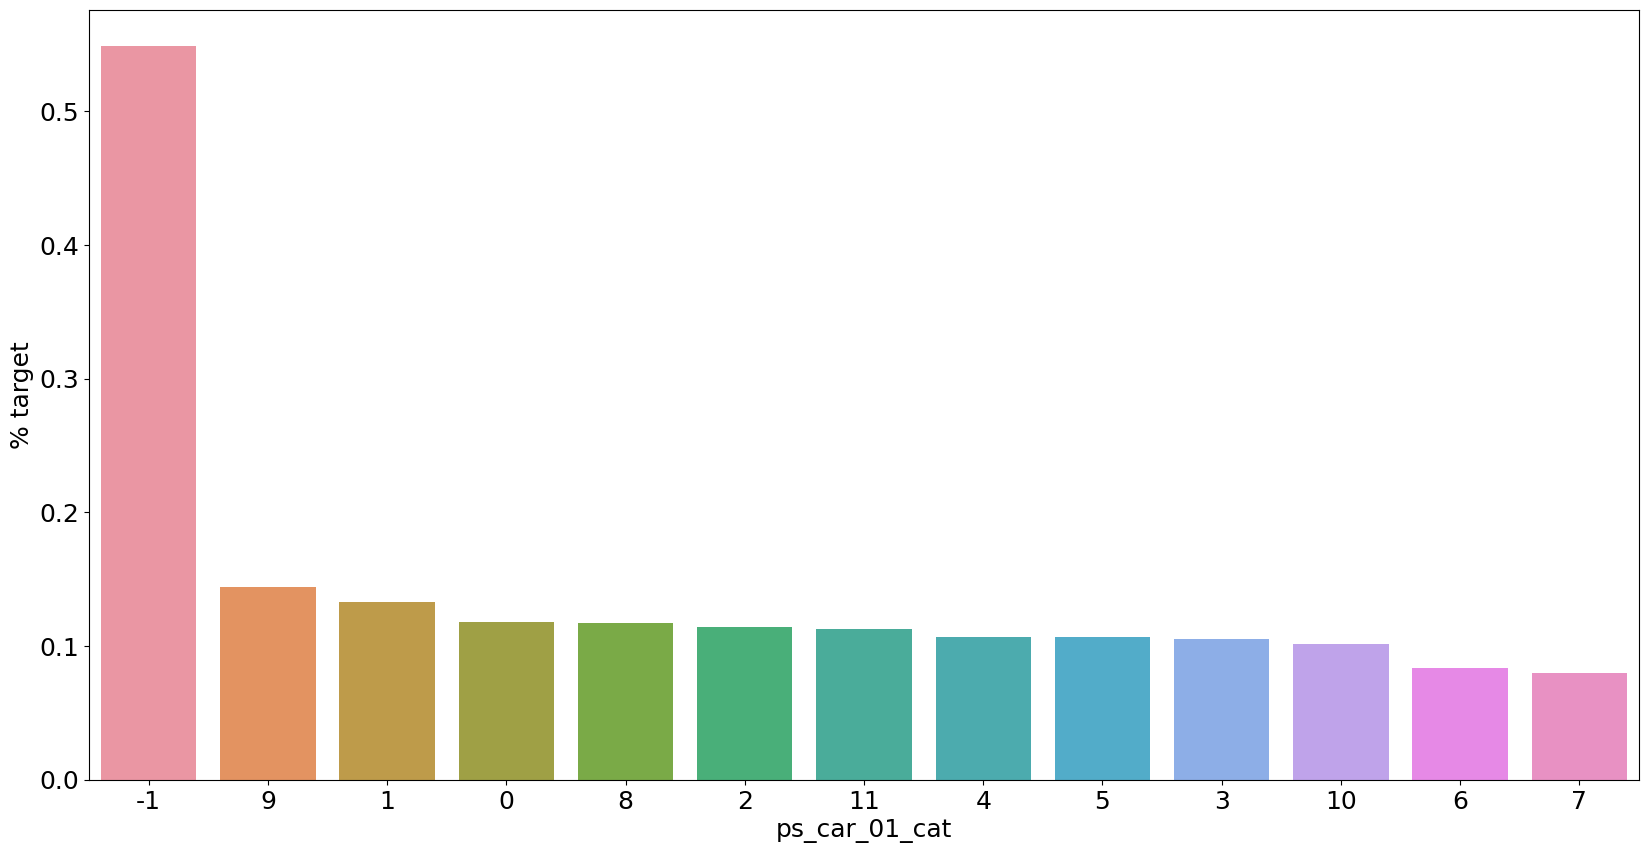

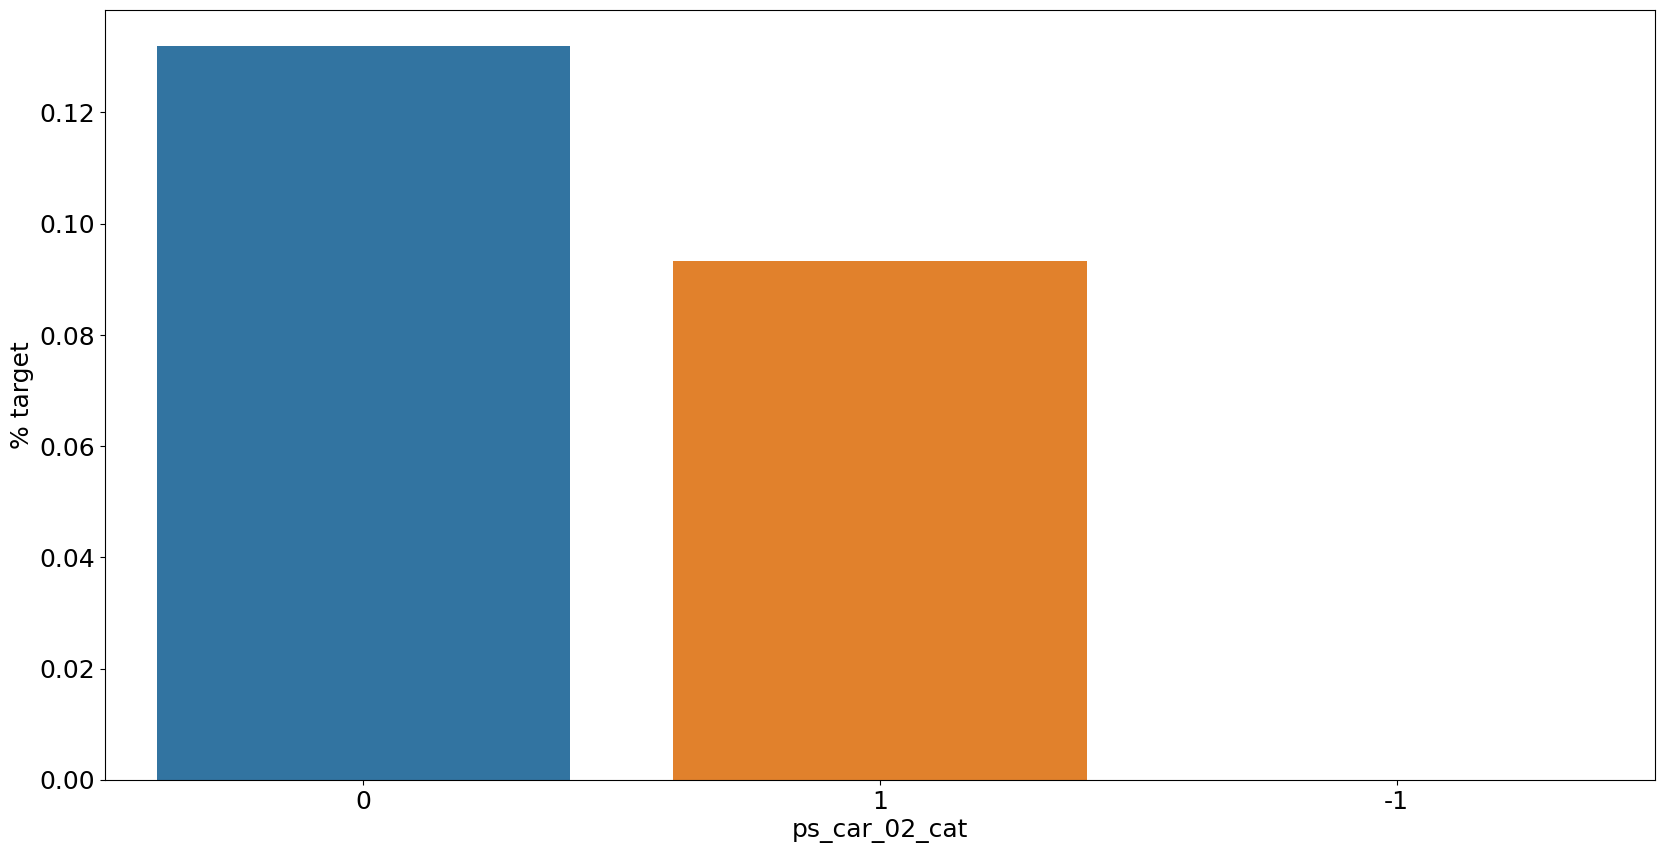

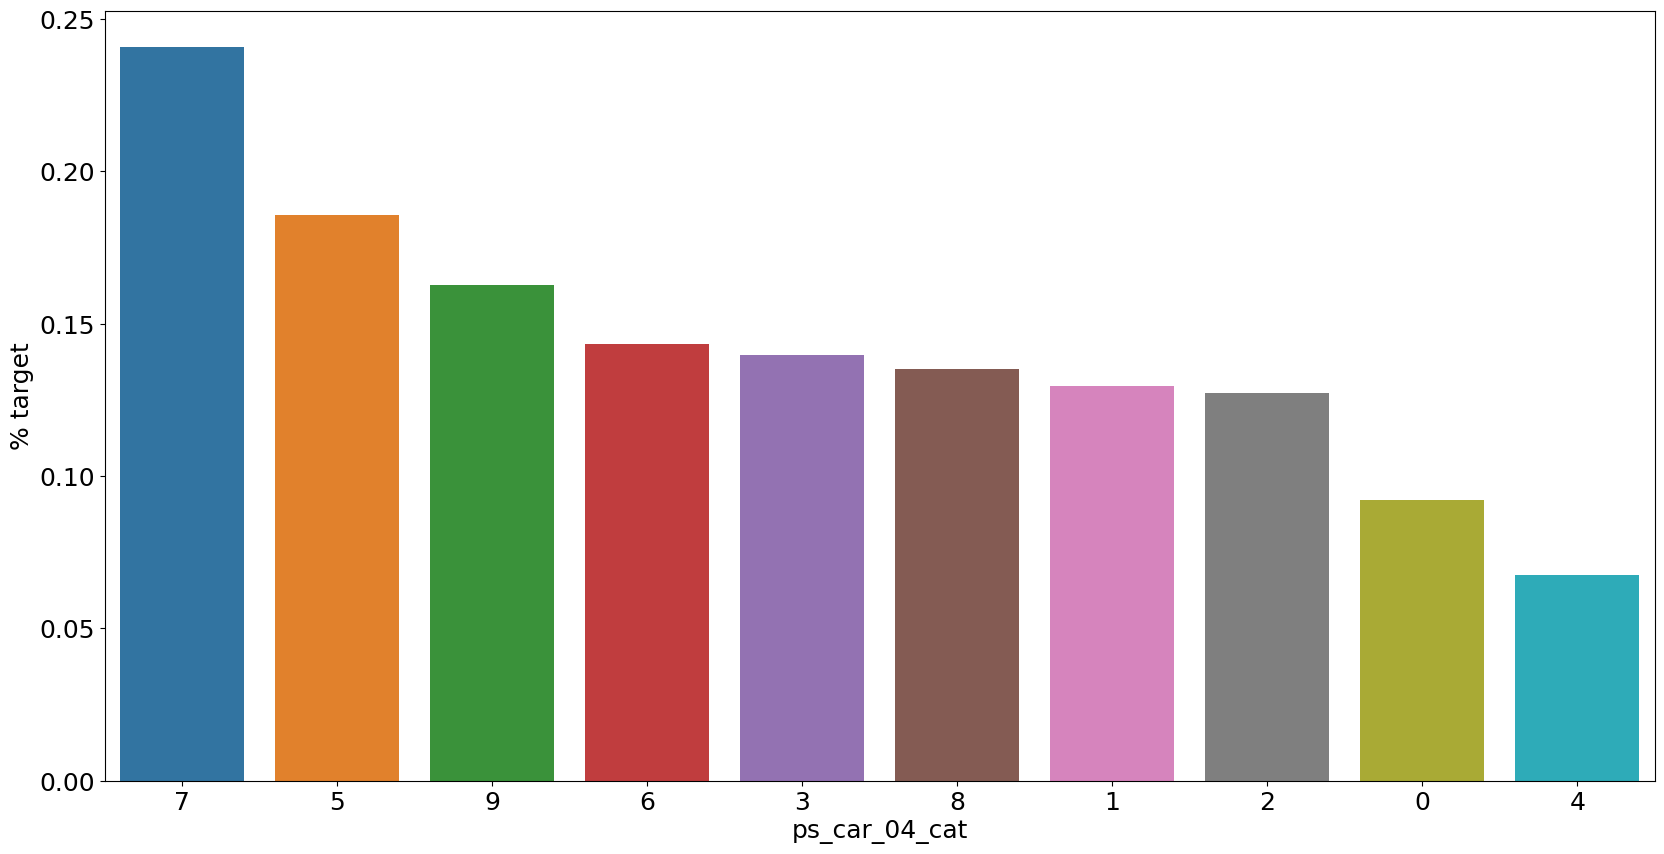

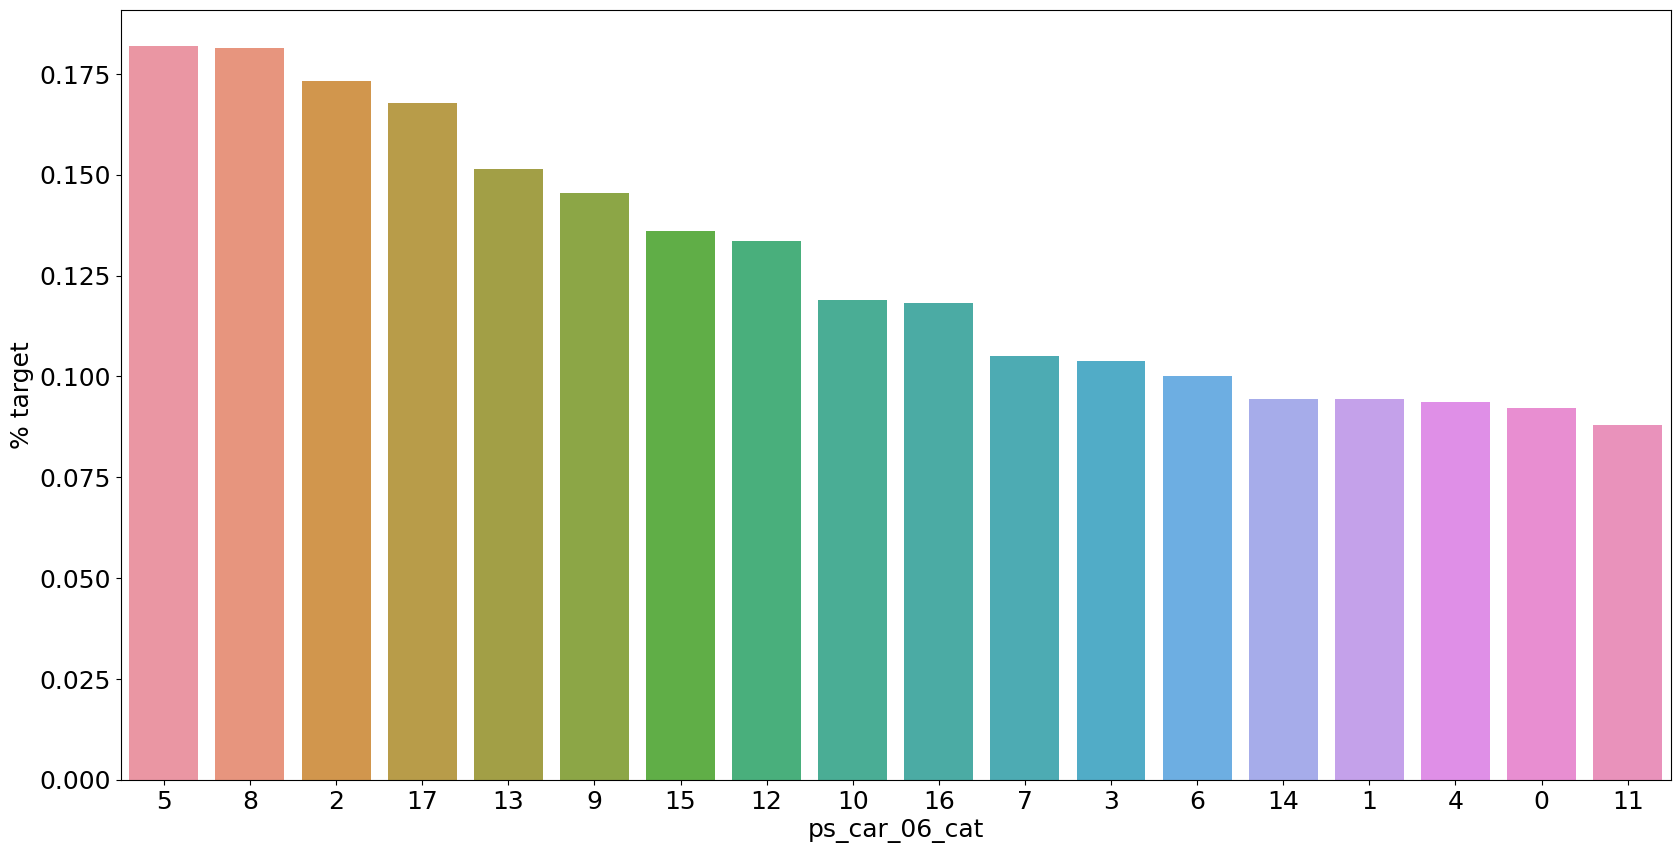

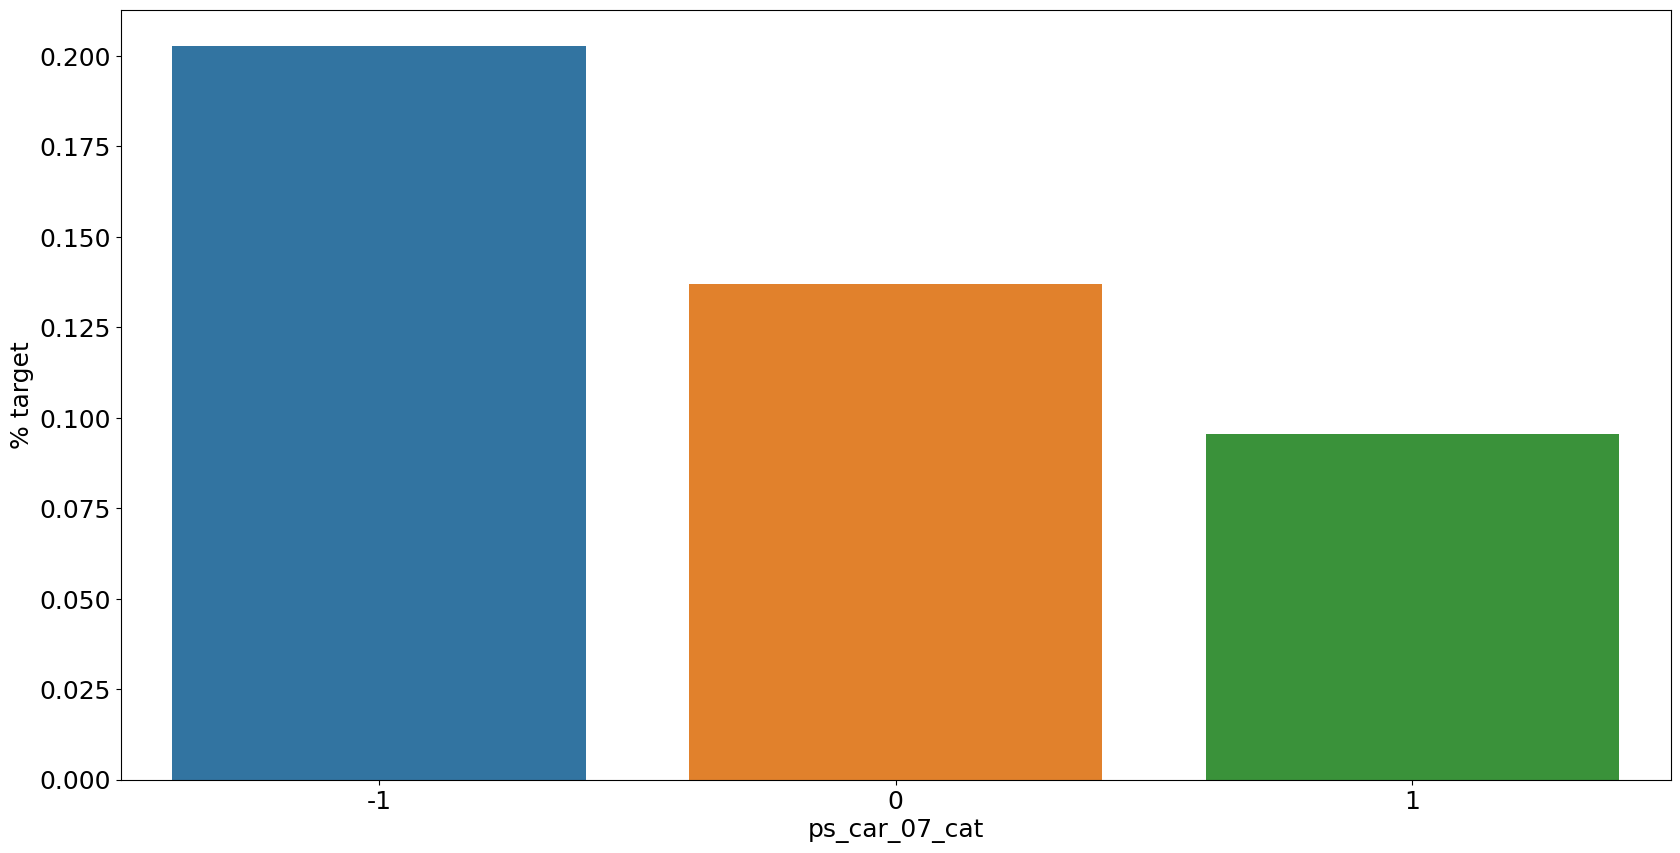

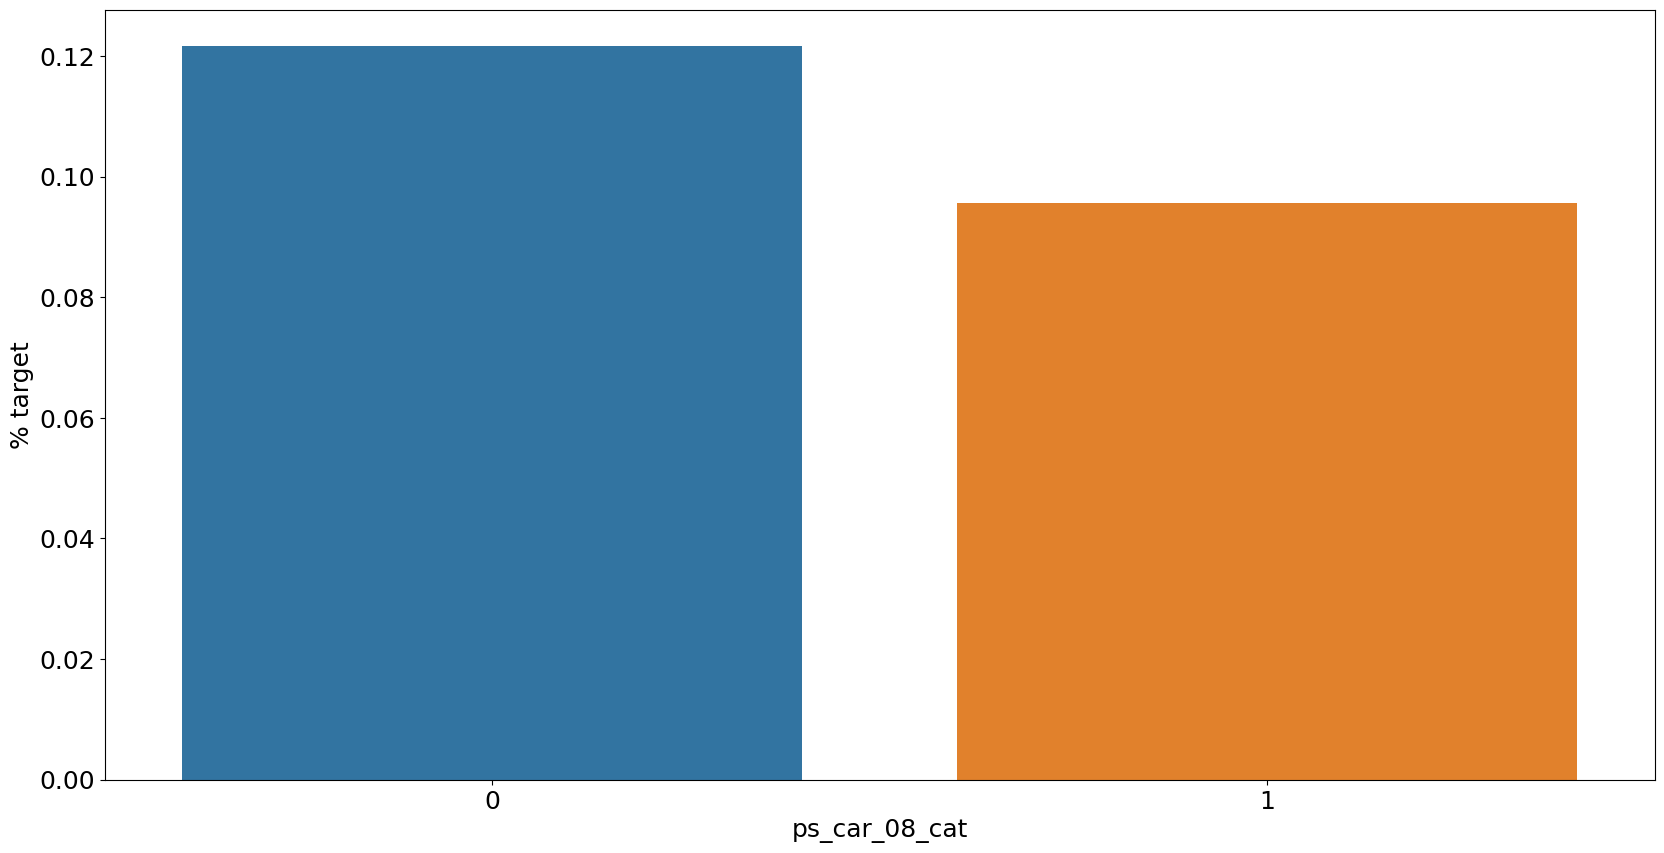

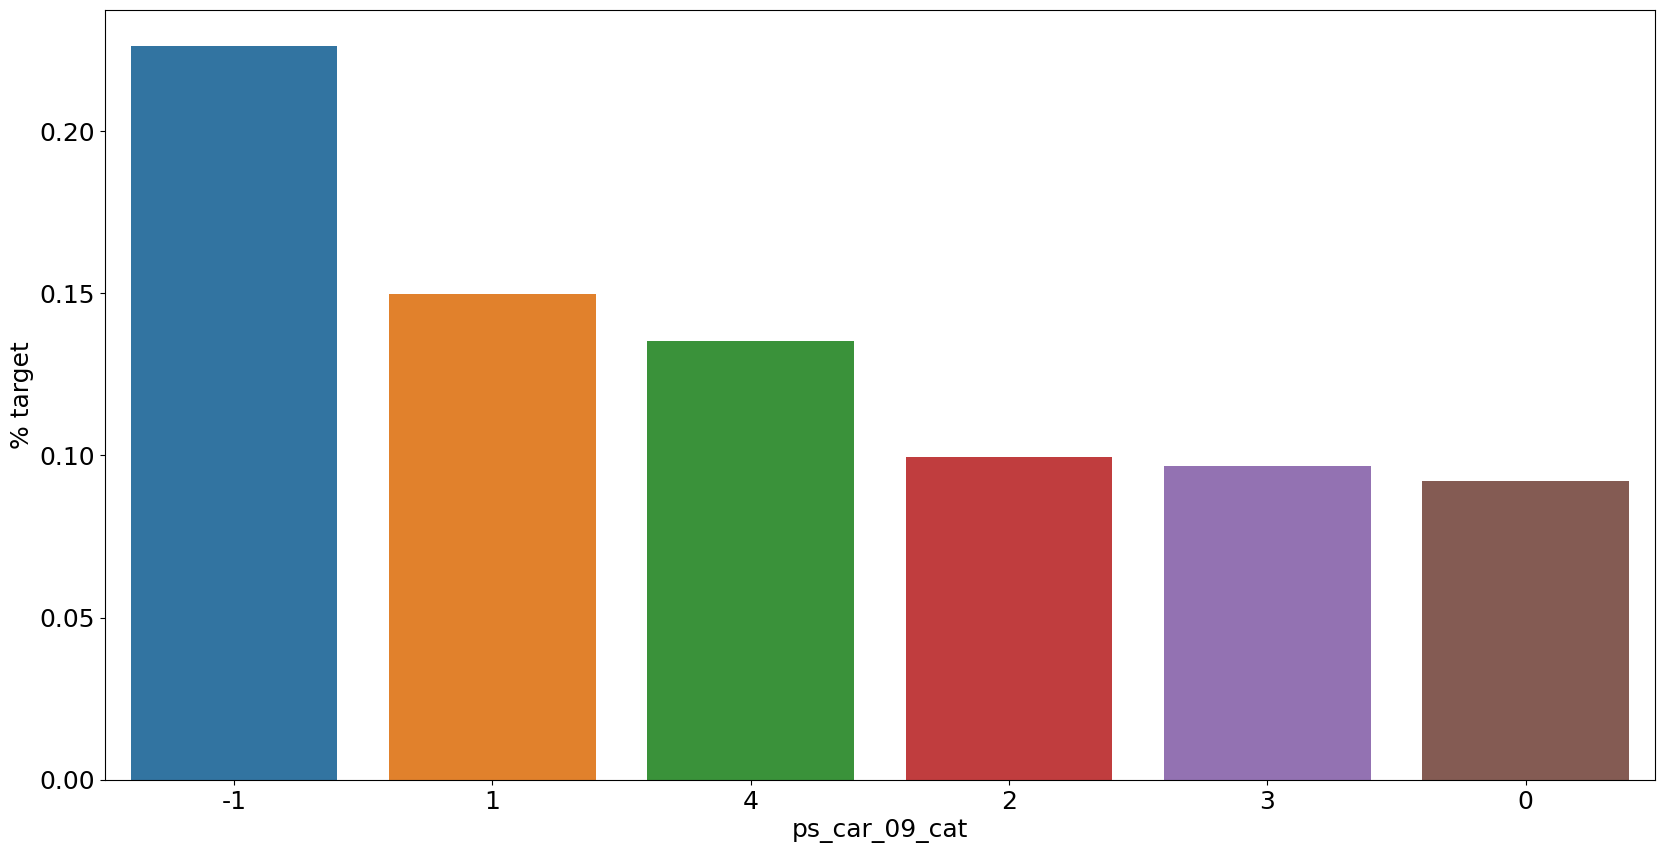

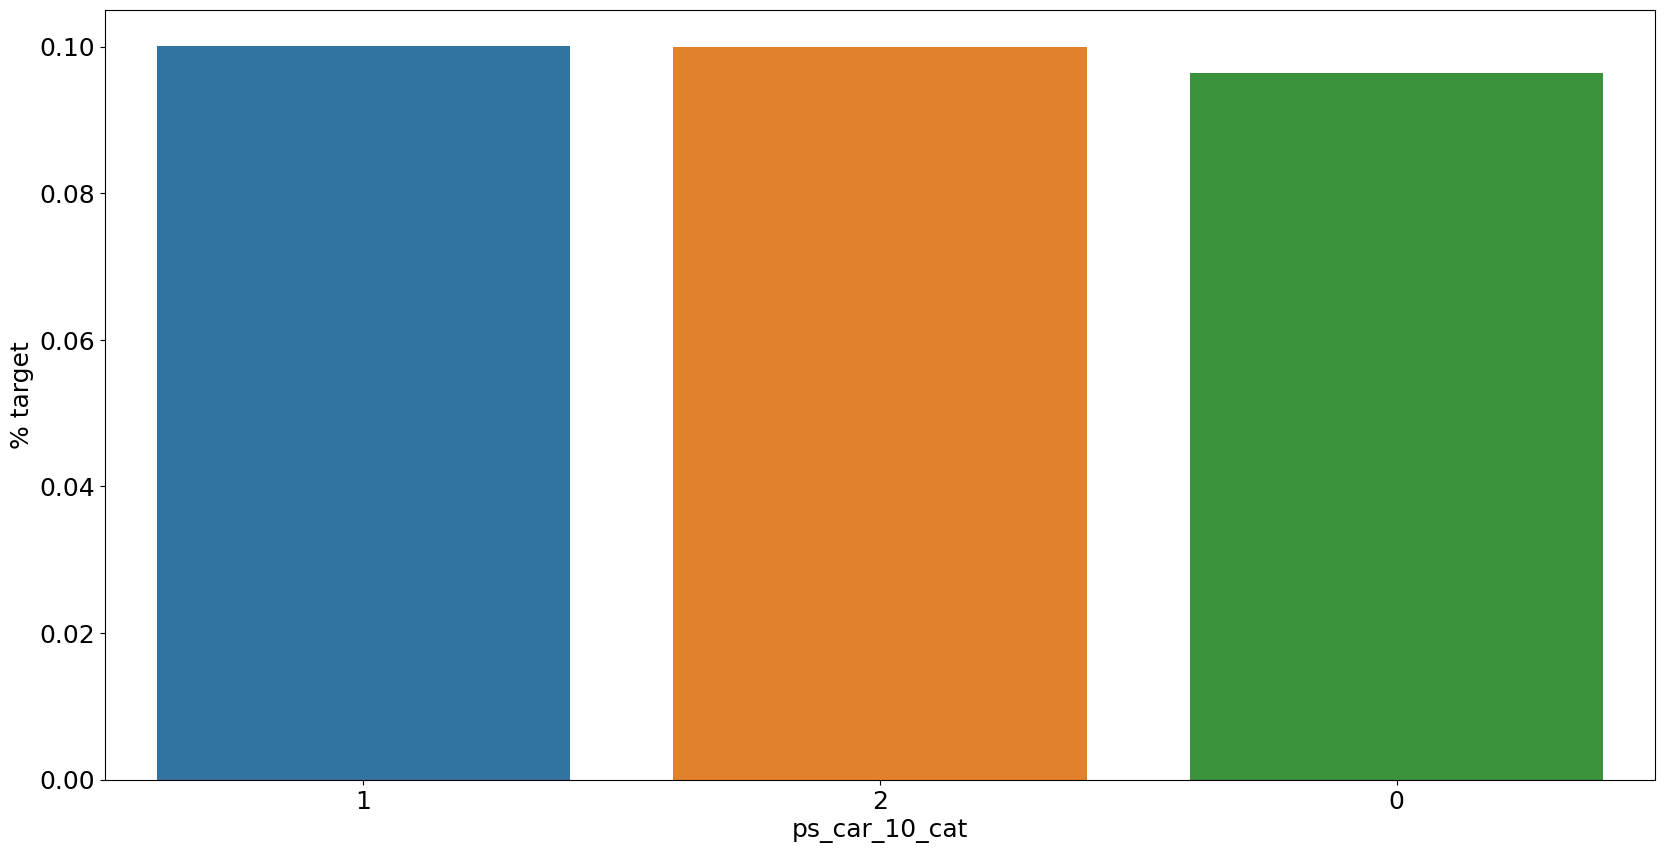

In [18]:
## Categorical variables
v = meta[(meta.level=='nominal')&(meta.keep)].index
# v = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
#        'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat',
#        'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat']

for f in v:
    plt.figure(figsize=(20,10))
    ## Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    ## Bar plot
    ## Order the bars descending on target mean
    sns.barplot(x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

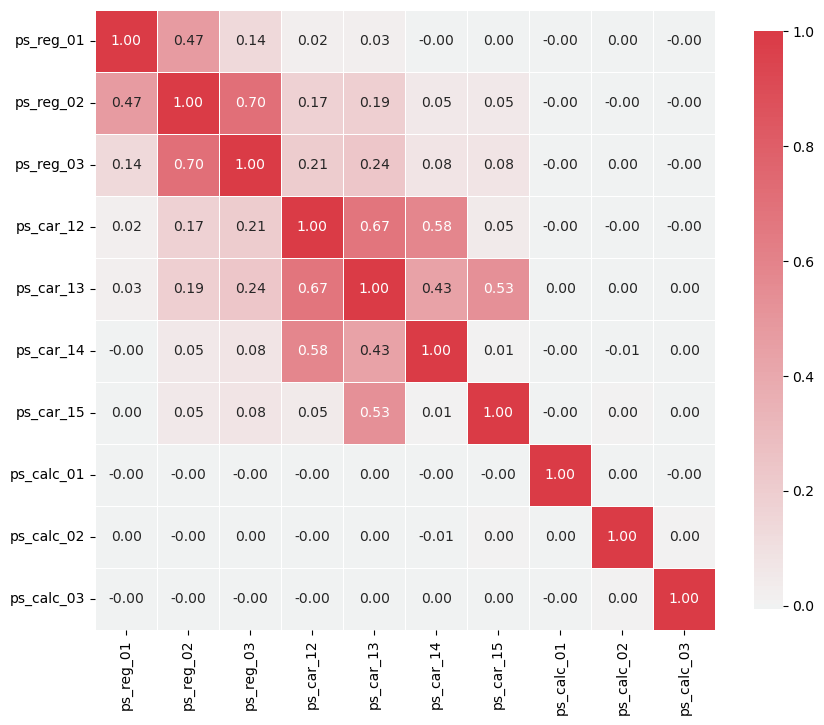

In [19]:
## Interval variables

def corr_heatmap(v):
    correlations = train[v].corr()

    ## Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', 
                square=True, linewidths=.5, annot=True, cbar_kws={'shrink':.75})
                # vmax: cmap의 최댓값, square: 그래프를 정사각형으로, annot: 각 셀에 문자 기입 
    plt.show();

v = meta[(meta.level=='interval')&(meta.keep)].index
corr_heatmap(v)
# 똑같이 따라했는데 상관관계가 차이난다. Imputer 함수가 바껴서 그런가??

There are a strong correlations between the variables:  
  
- ps_reg_02 and ps_reg_03 (0.7)
- ps_car_12 and ps_car13 (0.67)
- ps_car_12 and ps_car14 (0.58)
- ps_car_13 and ps_car15 (0.67)
  
Seaborn has some handy plots to visualize the (linear) relationship between variables. We could use a pairplot to visualize the relationship between the variables. But because the heatmap already showed the limited number of correlated variables, we'll look at each of the highly correlated variables separately.  
__NOTE__: I take a sample of the train data to speed up the process.

In [20]:
s = train.sample(frac=0.1)
# df.sample(n:int(return 개수), frac: float(return 비율), replace: bool(중복 추출), weights: str or array(가중치, 레이블마다 추출될 확률))

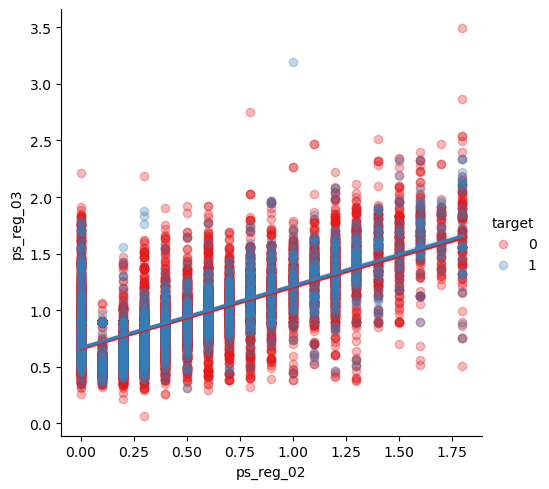

In [21]:
sns.lmplot(data=s, x='ps_reg_02', y='ps_reg_03', hue='target', palette='Set1', scatter_kws={'alpha': 0.3})
plt.show;

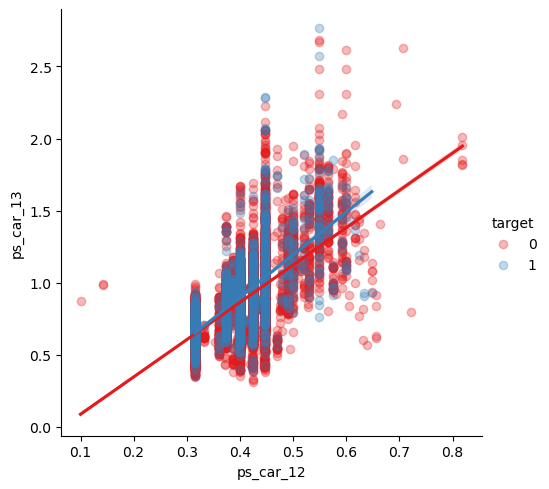

In [22]:
sns.lmplot(data=s, x='ps_car_12', y='ps_car_13', hue='target', palette='Set1', scatter_kws={'alpha': 0.3})
plt.show()

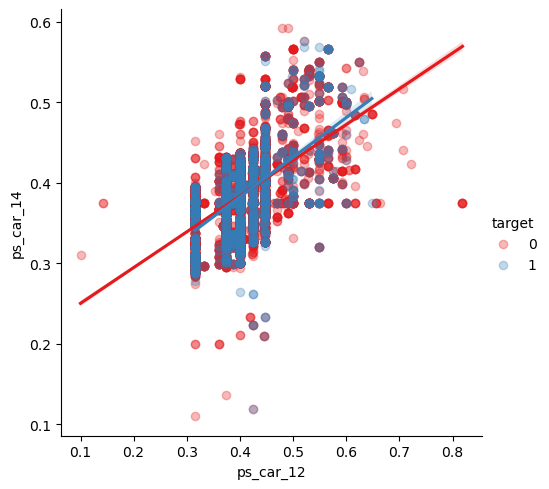

In [23]:
sns.lmplot(data=s, x='ps_car_12', y='ps_car_14', hue='target', palette='Set1', scatter_kws={'alpha': 0.3})
plt.show()

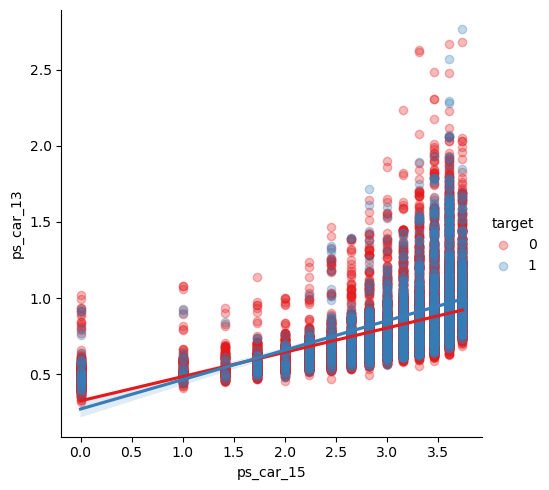

In [24]:
sns.lmplot(data=s, x='ps_car_15', y='ps_car_13', hue='target', palette='Set1', scatter_kws={'alpha': 0.3})
plt.show()

Allright, so now what? How can we decide which of the correlated variables to keep? We could perform Principal Component Analysis (PCA) on the variables to reduce the dimensions. In the AllState Claims Severity Competition I made [this kernel](https://www.kaggle.com/code/bertcarremans/reducing-number-of-numerical-features-with-pca/notebook) to do that. But as the number of correlated variables is rather low, we will let the model do the heavy-lifting.

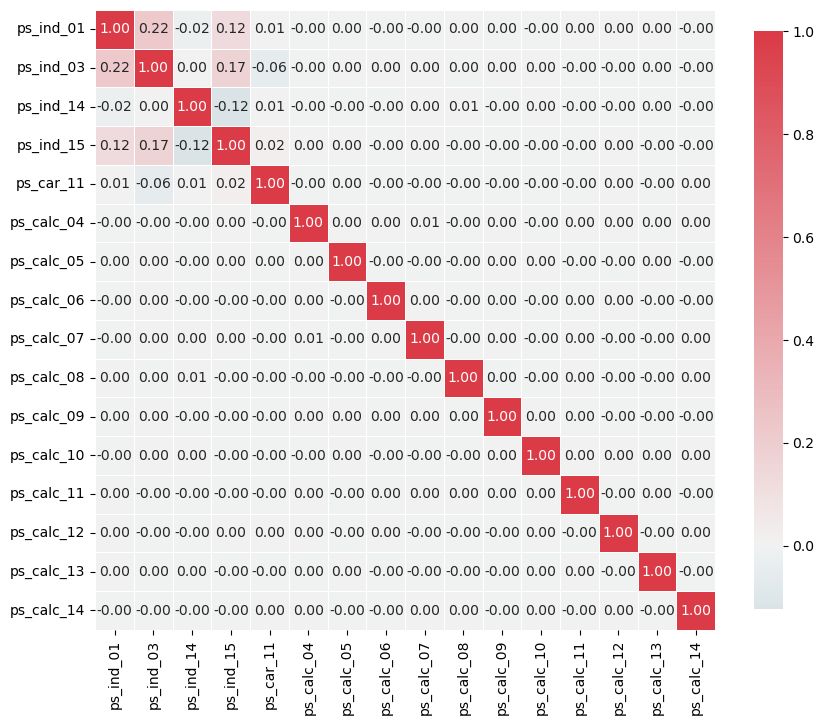

In [25]:
## Checking the correlations between ordinal variables
v = meta[(meta.level=='ordinal')&(meta.keep)].index
corr_heatmap(v)

### Feature engineering
  
__Creating dummy cariables__  
The values of the categorical variables do not represent any order or magnitude. For instance, category 2 is not twice the value of category 1. Therefore we can create dummy variables to deal with that. We drop the first dummy variable as this information can be derived from the other dummy variables generated for the categories of the original variable.

In [26]:
v = meta[(meta.level=='nominal')&(meta.keep)].index
print(f'Before dummification we have {train.shape[1]} variables in train')
train = pd.get_dummies(train, columns=v, drop_first=True)
# pd.get_dumies: 더미 변수 생성(원핫인코딩)
print(f'After dummification we have {train.shape[1]} variables in train')

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


In [27]:
## Creating interaction variables
v = meta[(meta.level=='interval')&(meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# PolynomialFeatures: 다항회귀, degree=차수, interaction_only=상호작용 피처 생성 여부, include_bias=상수(편향) 생성 여부
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names_out(v))
interactions.drop(v, axis=1, inplace=True)  ## Remove the original columns
## Concat the interaction variables to the train data
print(f'Before creating interactions we have {train.shape[1]} variables in train')
train = pd.concat([train, interactions], axis=1)
# pd.get_dumies: 더미 변수 생성(원핫인코딩)
print(f'After creating interactions we have {train.shape[1]} variables in train')

Before creating interactions we have 109 variables in train
After creating interactions we have 164 variables in train


### Feature selection
__Removing features with low or zero variance__  
  
Personally, I prefer to let the classifier algorithm chose which features to keep. But there is one thing that we can do ourselves. That is removing features with no or a very low variance. Sklearn has a handy method to do that: __VarianceThreshold__. By default it removes features with zero variance. This will not be applicable for this competition as we saw there are no zero-variance variables in the previous steps. But if we would remove features with less than 1% variance, we would remove 31 variables.

### DeepL 번역
  
__분산이 낮거나 0인 특징 제거하기__
  
개인적으로 저는 분류기 알고리즘이 어떤 특징을 유지할지 선택하게 하는 것을 선호합니다. 하지만 우리가 직접 할 수 있는 일이 한 가지 있습니다. 분산이 없거나 매우 낮은 특징을 제거하는 것입니다. Sklearn에는 이를 위한 편리한 방법이 있습니다: __VarianceThreshold__. 기본적으로 분산이 0인 피처를 제거합니다. 이전 단계에서 분산이 0인 변수가 없다는 것을 확인했기 때문에 이 대회에는 적용되지 않습니다. 하지만 분산이 1% 미만인 특징을 제거하면 31개의 변수가 제거됩니다.

In [28]:
selector = VarianceThreshold(threshold=.01) # 분산이 threshold보다 작은 열 제거
selector.fit(train.drop(['id', 'target'], axis=1))  ## Fit to train without id and target variables

f = np.vectorize(lambda x: not x)   ## Fuction to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print(f'{len(v)} variables have too low variance.')
print(f'These variables are {list(v)}')

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


We would lose rather many variables if we would select based on variance. But because we do not have so many variables, we'll let the classifier chose. For data sets with many more variables this could reduce the processing time.  
  
Sklearn also comes with other feature selection methods. One of these methods is SelectFromModel in which you let another classifier select the best features and continue with these. Below I'll show you how to do that with a Random Forest.  
  
__DeepL 번역__  
분산에 따라 선택하면 많은 변수를 잃게 됩니다. 하지만 변수가 많지 않기 때문에 분류기가 선택하도록 하겠습니다. 더 많은 변수가 있는 데이터 집합의 경우 처리 시간을 줄일 수 있습니다.  
  
Sklearn에는 다른 특징 선택 방법도 있습니다. 이러한 방법 중 하나는 다른 분류자가 최상의 특징을 선택하도록 하고 계속 진행하도록 하는 SelectFromModel입니다. 아래에서는 무작위 포리스트를 사용하여 이를 수행하는 방법을 보여드리겠습니다.

### Selecting features with a Random Forest and SelectFromModel
Here we'll base feature selection on the feature importances of a random forest. With Sklearn's SelectFromModel you can then specify how many variables you want to keep. You can set a threshold on the level of feature importance manually. But we'll simply select the top 50% best variables.  
  
The code in the cell below is borrowed from the GitHub repo of Sebastian Raschka. This repo contains code samples of his book Python Machine Learning, which is an absolute must to read.  
  
__DeepL 번역__  
여기서는 Random Forest의 기능 중요도에 따라 기능을 선택하겠습니다. 그런 다음 Sklearn의 SelectFromModel을 사용하여 유지하려는 변수의 수를 지정할 수 있습니다. 기능 중요도 수준에 대한 임계값을 수동으로 설정할 수 있습니다. 하지만 여기서는 단순히 상위 50%의 가장 좋은 변수를 선택하겠습니다.  
  
아래 셀의 코드는 Sebastian Raschka의 GitHub 리포지토리에서 빌려온 것입니다. 이 리포지토리에는 그의 저서 Python Machine Learning의 코드 샘플이 포함되어 있으므로 꼭 읽어보시기 바랍니다.


In [29]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1] # step=-1로 내림차순 정렬

for f in range(X_train.shape[1]):
    print('%2d) %-*s %f' % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))
    # print(f'{f+1}) %-*s %f' % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.021156
 2) ps_car_13                      0.017333
 3) ps_car_13^2                    0.017259
 4) ps_car_12 ps_car_13            0.017238
 5) ps_car_13 ps_car_14            0.017193
 6) ps_reg_03 ps_car_13            0.017031
 7) ps_car_13 ps_car_15            0.016799
 8) ps_reg_01 ps_car_13            0.016779
 9) ps_reg_03 ps_car_14            0.016215
10) ps_reg_03 ps_car_12            0.015512
11) ps_reg_03 ps_car_15            0.015110
12) ps_car_14 ps_car_15            0.015070
13) ps_car_13 ps_calc_01           0.014777
14) ps_car_13 ps_calc_03           0.014711
15) ps_reg_01 ps_reg_03            0.014691
16) ps_car_13 ps_calc_02           0.014691
17) ps_reg_02 ps_car_13            0.014649
18) ps_reg_01 ps_car_14            0.014347
19) ps_reg_03^2                    0.014223
20) ps_reg_03                      0.014173
21) ps_reg_03 ps_calc_02           0.013825
22) ps_reg_03 ps_calc_01           0.013735
23) ps_reg_03 ps_calc_03        

In [30]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print(f'Number of features before selection: {X_train.shape[1]}')
n_features = sfm.transform(X_train).shape[1]
print(f'Number of features after selection: {n_features}')
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 162


c:\Users\why\miniconda3\envs\study\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of features after selection: 81


In [31]:
train = train[selected_vars+['target']]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216940 entries, 0 to 216939
Data columns (total 82 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ps_ind_01              216940 non-null  int64  
 1   ps_ind_03              216940 non-null  int64  
 2   ps_ind_15              216940 non-null  int64  
 3   ps_reg_01              216940 non-null  float64
 4   ps_reg_02              216940 non-null  float64
 5   ps_reg_03              216940 non-null  float64
 6   ps_car_11              216940 non-null  int64  
 7   ps_car_12              216940 non-null  float64
 8   ps_car_13              216940 non-null  float64
 9   ps_car_14              216940 non-null  float64
 10  ps_car_15              216940 non-null  float64
 11  ps_calc_01             216940 non-null  float64
 12  ps_calc_02             216940 non-null  float64
 13  ps_calc_03             216940 non-null  float64
 14  ps_calc_04             216940 non-nu

### Feature scaling
  
As mentioned before, we can apply standard scaling to the training data. Some classifiers perform better when this is done.

In [32]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])

In [33]:
scaler

StandardScaler()

## Conclusion
Hopefully this notebook helped you with some tips on how to start with this competition. Feel free to vote for it. And if you have questions, post a comment.